#Imports

In [33]:
!pip -q install cyrtranslit


In [34]:
import pandas as pd
import re, unicodedata
import seaborn as sns
import numpy as np
from cyrtranslit import to_latin

#Loading Files

In [2]:
n1_csv= pd.read_csv("n1.csv")

In [29]:
rts_csv= pd.read_csv("rts.csv")

# Data Cleaning

## Remove articles before Oct 31 2024

Removing the first column from n1 csv that only says "NewsArticle" as it is not useful

In [3]:
n1_csv = n1_csv.drop(columns=n1_csv.columns[0])

In [4]:
n1_csv.to_csv("n1.csv", index=False)

Remove the rows that are before November 1st 2024

The problem is that some of the dates from data collected on different days was in a different format. Therefore, I had to use mixed format

In [5]:
n1_csv["datePublished"]=n1_csv["datePublished"].astype(str).str.strip()
n1_csv["datePublished"] = pd.to_datetime(n1_csv["datePublished"].astype(str).str.strip(),
    errors="coerce",
    utc=True,
    format="mixed")


In [6]:
cutoff=pd.Timestamp("2024-10-31", tz="UTC")
n1_csv=n1_csv[n1_csv["datePublished"] >= cutoff].copy()

In [7]:
n1_csv.shape

(34687, 4)

Dataset now has 34687 articles

##Remove duplicates

In [8]:
n1_csv = n1_csv.drop_duplicates()

In [9]:
n1_csv.shape

(34673, 4)

In [30]:
rts_csv.shape

(3400, 3)

In [31]:
rts_csv = rts_csv.drop_duplicates()


In [32]:
rts_csv.shape

(3367, 3)

 N1 Dataset now has 34673 articles

 RTS Dataset now has 3367 articles

In [ ]:
counts_per_month=n1_csv.groupby(n1_csv["datePublished"].dt.to_period("M")).size()
print(counts_per_month)

datePublished
2024-10      84
2024-11    2418
2024-12    2570
2025-01    2409
2025-02    2341
2025-03    2943
2025-04    2504
2025-05    2418
2025-06    2403
2025-07    2515
2025-08    2236
2025-09    2118
2025-10    2318
2025-11    2253
2025-12    2194
2026-01     949
Freq: M, dtype: int64


/tmp/ipython-input-2866706765.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  counts_per_month=n1_csv.groupby(n1_csv["datePublished"].dt.to_period("M")).size()


In [ ]:
n1_csv.to_csv("n1_cleaned.csv", index=False)

## Cyrilics to Latin

Since RTS dataset is completely in cyrilic script I will change it to latin script for simplicity

In [38]:
rts_csv['headline']=rts_csv['headline'].astype(str).map(to_latin)

In [40]:
rts_csv['datePublished']=rts_csv['datePublished'].astype(str).map(to_latin)

In [42]:
rts_csv.to_csv("rts_latin.csv", index=False)

#Label headlines related to the protests

In [ ]:
from transformers.pipelines import pipeline

#Using xlm-roberta-large-xnli

In [ ]:
headlines=n1_csv['headline']

In [ ]:


clf = pipeline(
    "zero-shot-classification",
    model="joeddav/xlm-roberta-large-xnli",
    device=0,
)
results=[]
for i in headlines:

  results.append(clf(
      i,
      candidate_labels=["vezano za proteste", "nije vezano za proteste"],
      hypothesis_template="Ova vest je {}."))
  print(results[-2:-1])




Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


Streaming output truncated to the last 5000 lines.
[{'sequence': 'Žanetić: Godina 2024. je lokalno bila tužna, globalno - nervozna', 'labels': ['vezano za proteste', 'nije vezano za proteste'], 'scores': [0.5664504170417786, 0.43354955315589905]}]
[{'sequence': '021.rs: Dečak doneo nož u školu u Novom Sadu - roditelji, umesto škole, obavestili policiju', 'labels': ['vezano za proteste', 'nije vezano za proteste'], 'scores': [0.564384400844574, 0.435615599155426]}]
[{'sequence': 'I kragujevački studenti nastavljaju blokadu i u novogodišnjoj noći', 'labels': ['vezano za proteste', 'nije vezano za proteste'], 'scores': [0.9978217482566833, 0.0021782477851957083]}]
[{'sequence': '"Prvi upit za doček smo dobili u junu": Kako teku pripreme za novogodišnju noć u Skadarliji', 'labels': ['vezano za proteste', 'nije vezano za proteste'], 'scores': [0.6002987623214722, 0.3997012972831726]}]
[{'sequence': 'Petar Benčina: Biti uz studente je stvar ljudskosti', 'labels': ['vezano za proteste', 'nije

In [ ]:
related=[]
for i in results:

    related.append(i['labels'][0])


Those that have the first item in labels as 'vezano za proteste' is related to the protests while 'nije vezano za proteste' is not related to the protests

In [ ]:
n1_csv["Related"]=related

In [ ]:
n1_csv["Scores"]=scores

In [ ]:
n1_csv_related=n1_csv[n1_csv["Related"]=='vezano za proteste'].copy()

In [ ]:
n1_csv_related.shape

(31160, 6)

In [ ]:
n1_csv_related.to_csv("n1_related.csv", index=False)

In [ ]:
n1_csv.to_csv("n1_cleaned_with_scores.csv", index=False)

In [ ]:
n1_csv["Related"].value_counts()

,count
Related,
vezano za proteste,31160
nije vezano za proteste,3513


In [ ]:
headlines[:]

,headline
0,Iskliznuli vagoni kod Kosjerića i dalje stoje ...
1,Roditelji zabrinuti za bezbednost dece u hali ...
2,Novi DSS neće na sastanak s evroparlamentarcim...
3,Poskupele auto-škole u Nišu: Da li je cena od ...
4,Ministarstvo razmatra skraćenje časova na 30 m...
...,...
34682,Novi kružni tok u Košutnjaku stvara glavobolje...
34683,MMR vakcinu primilo 88 odsto dvogodišnjaka – d...
34684,Na pomolu promena vremena - stiže zahlađenje
34685,Dve osobe povređene u saobraćajnoj nezgodi na ...


In [ ]:
headlines.to_csv("headlines.txt", index=False, header=False)

##ChatGPT labeled data

Here I gave ChatGPT a prompt to label all of the headlines as related and unrelated to the protest

***! in progress***

In [ ]:
gpt_n1= pd.read_csv("headlines_labeled.csv")

In [ ]:
n1_csv['gpt_related']=gpt_n1['label']

In [ ]:
gpt_n1['label'].value_counts()

,count
label,
UNRELATED,26753
UNCERTAIN,5349
RELATED,2391


In [ ]:
n1_csv[n1_csv["gpt_related"]=='UNCERTAIN']

,headline,url,datePublished,author,Related,Scores,gpt_related
10,Naprednjački amandman dovodi u opasnost da se ...,/vesti/naprednjacki-amandman-dovodi-u-opasnost...,2026-01-17 21:00:00+00:00,"{'@type': 'Person', 'name': 'Mladen SavatoviÄ\...",vezano za proteste,"[0.7668924927711487, 0.2331075221300125]",UNCERTAIN
13,(FOTO) Protest u Novom Sadu kroz objektiv foto...,/foto/foto-protest-u-novom-sadu-kroz-objektiv-...,2026-01-17 19:54:34.186516+00:00,"{'@type': 'Person', 'name': 'N1 Beograd'}",vezano za proteste,"[0.999207615852356, 0.0007924024830572307]",UNCERTAIN
24,Večeras protest studenata u Novom Sadu - preds...,/vesti/veceras-protest-studenata-u-novom-sadu-...,2026-01-17 08:35:35.717316+00:00,"{'@type': 'Person', 'name': 'N1 Beograd'}",vezano za proteste,"[0.9994884133338928, 0.0005116386455483735]",UNCERTAIN
36,"""Lukava namera EU da nam preuzme vozače"": Kami...",/vesti/lukava-namera-eu-da-nam-preuzme-vozace-...,2026-01-16 20:37:03.053874+00:00,"{'@type': 'Person', 'name': 'Jelena Mirković'}",vezano za proteste,"[0.9990085959434509, 0.0009914598194882274]",UNCERTAIN
44,"""Jedni povređeni, za druge pomilovanje umesto ...",/vesti/studenti-pravnog-podsetili-gazenje-sonj...,2026-01-16 18:16:27.074330+00:00,"{'@type': 'Person', 'name': 'FoNet '}",vezano za proteste,"[0.755549430847168, 0.24445049464702606]",UNCERTAIN
...,...,...,...,...,...,...,...
34408,Građevinska inženjerka: U dokumentaciji ne vid...,/vesti/gradjevinska-inzinjerka-u-dokumentaciji...,2024-11-03 15:58:26+00:00,"{'@type': 'Person', 'name': 'nova.rs '}",vezano za proteste,"[0.8228630423545837, 0.17713697254657745]",UNCERTAIN
34432,Dačić: Troje povređenih u Novom Sadu i dalje u...,/vesti/dacic-troje-povredjenih-u-novom-sadu-i-...,2024-11-03 08:32:52+00:00,"{'@type': 'Person', 'name': 'Beta '}",vezano za proteste,"[0.7728744149208069, 0.22712557017803192]",UNCERTAIN
34449,"""Pripremili smo šatore i noćimo na mostu"": Akt...",/vesti/pripremili-smo-satore-i-nocimo-na-mostu...,2024-11-02 19:20:16+00:00,"{'@type': 'Person', 'name': 'N1 Beograd'}",vezano za proteste,"[0.9985437989234924, 0.001456234254874289]",UNCERTAIN
34457,Dašić: Vlasti nije problem da otkrije koliko k...,/vesti/dasic-vlasti-nije-problem-da-otkrije-ko...,2024-11-02 17:18:18+00:00,"{'@type': 'Person', 'name': 'N1 Beograd'}",vezano za proteste,"[0.58477383852005, 0.41522613167762756]",UNCERTAIN


#Manually labeling random 500 articles

In [ ]:
random_headlines = n1_csv.sample(n=500, random_state=42)
random_headlines.to_csv("random_headlines.csv", index=False, header=False)

Here I manually labeled around 500 randomly selected articles and

In [10]:
random_headlines = pd.read_csv("random_headlines.csv", sep=";", engine="python")


In [11]:
related=[]
for i in random_headlines["Related"]:

  if i=="vezano za proteste":
    related.append("RELATED")
  else:
    related.append("UNRELATED")
random_headlines["Related"]=related



In [17]:

from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(random_headlines["true_label"],random_headlines["Related"])
print(cf_matrix)

[[425   0  47]
 [  8   0   2]
 [ 76   0  20]]


In [24]:
labels = ["RELATED", "UNCERTAIN", "UNRELATED"]

cm_related= pd.crosstab(
    random_headlines["true_label"],
    random_headlines["Related"],
    rownames=["True Values"],
    colnames=["Predicted"],
    dropna=False
).reindex(index=labels, columns=labels, fill_value=0)

cm_related


Predicted,RELATED,UNCERTAIN,UNRELATED
True Values,,,
RELATED,425,0,47
UNCERTAIN,8,0,2
UNRELATED,76,0,20


In [26]:
labels = ["RELATED", "UNCERTAIN", "UNRELATED"]

cm_gpt= pd.crosstab(
    random_headlines["true_label"],
    random_headlines["gpt_related"],
    rownames=["True Values"],
    colnames=["Predicted"],
    dropna=False
).reindex(index=labels, columns=labels, fill_value=0)

cm_gpt

Predicted,RELATED,UNCERTAIN,UNRELATED
True Values,,,
RELATED,44,84,343
UNCERTAIN,1,3,6
UNRELATED,3,16,77


<Axes: xlabel='Predicted', ylabel='True Values'>

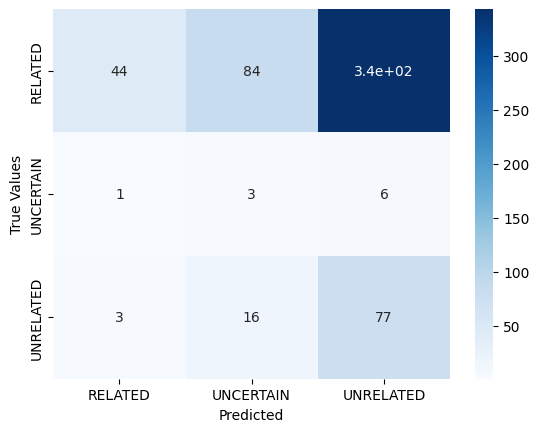

In [28]:
sns.heatmap(cm_gpt, annot=True, cmap='Blues')

<Axes: xlabel='Predicted', ylabel='True Values'>

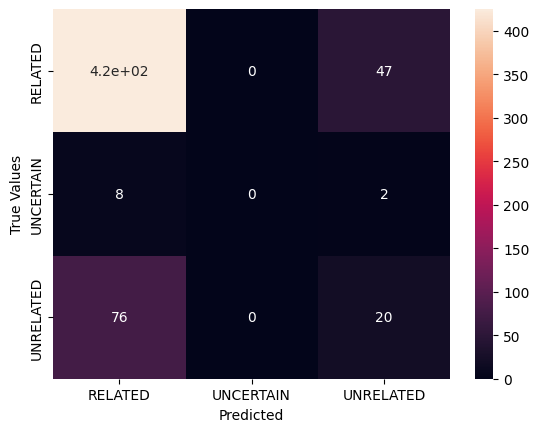

In [25]:
sns.heatmap(cm_related, annot=True)

In [22]:
from sklearn.metrics import classification_report

print(classification_report(
    random_headlines["true_label"],
    random_headlines["Related"],
    labels=["RELATED","UNCERTAIN","UNRELATED"]
))

              precision    recall  f1-score   support

     RELATED       0.83      0.90      0.87       472
   UNCERTAIN       0.00      0.00      0.00        10
   UNRELATED       0.29      0.21      0.24        96

    accuracy                           0.77       578
   macro avg       0.37      0.37      0.37       578
weighted avg       0.73      0.77      0.75       578



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#Word Cloud